In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier)
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV
import optuna

In [2]:
# Загружаем данные
data = pd.read_csv('data/ic50_data.csv')

Для выполнения задания необходимо создать бинарный столбец, который будет показывать, превышает ли значение IC50 медианное значение по выборке. Этот столбец станет целевой переменной для задачи классификации.

In [3]:
# Вычислим медиану по столбцу IC50_log
ic50_median = data['IC50_log'].median()

# Создаем бинарный столбец, показывающий, больше ли значение IC50_log медианы
data['IC50_log_binary'] = (data['IC50_log'] > ic50_median).astype(int)

# Убираем переменную, на основе которой был создан бинарный целевой признак
data = data.drop(columns=['IC50_log'])

Перед тем как приступить к дальнейшей работе, необходимо проверить баланс классов.

In [4]:
# Проверяем баланс классов
print(data['IC50_log_binary'].value_counts())
print(data['IC50_log_binary'].value_counts(normalize=True))

IC50_log_binary
0    465
1    464
Name: count, dtype: int64
IC50_log_binary
0    0.500538
1    0.499462
Name: proportion, dtype: float64


Баланс классов почти идеальный — примерно 50/50, значит с дисбалансом проблем нет.

In [5]:
# Разделяем данные и убираем целевую переменную
X = data.drop(columns=['IC50_log_binary'])
y = data['IC50_log_binary']

In [ ]:
# Разделение данных (70% тренировочные, 30% тестовые)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Тренировочные данные: {X_train.shape[0]}")
print(f"Тестовые данные: {X_test.shape[0]}")

Тренировочные данные: 650
Тестовые данные: 279


In [7]:
# Инициализация моделей со стандартными параметрами
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradient Boosting': HistGradientBoostingClassifier(random_state=42, loss='log_loss'),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
}

In [8]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает классификационную модель и возвращает accuracy и F1-score"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1-score': round(f1_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
    }

In [9]:
# Оценка базовых моделей (без подбора параметров)
base_results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    base_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': False
    })
    
base_results = pd.DataFrame(base_results)
display(base_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.7563,0.7733,0.7532,0.7945,False
1,Random Forest,0.7563,0.7655,0.7708,0.7603,False
2,CatBoost,0.7491,0.7697,0.7405,0.8014,False
4,HistGradient Boosting,0.7384,0.7542,0.7417,0.7671,False
3,Gradient Boosting,0.7276,0.7467,0.7273,0.7671,False
5,Extra Trees,0.6989,0.7143,0.7095,0.7192,False


На начальном этапе модели обучались без настройки гиперпараметров. Наилучший показатель Accuracy продемонстрировала модель XGBoost с результатом 0.7563, что свидетельствует о её способности хорошо классифицировать превышение медианного значения IC50. Модель Extra Trees показала наихудшие результаты по всем метрикам, включая Accuracy (0.6989) и F1-score (0.7143), что указывает на необходимость улучшения.

In [ ]:
"""
Определяем словарь param_grid с диапазонами гиперпараметров для каждой модели.
- Числовые параметры задаются как кортеж (min, max) и:
  - преобразуются в списки при использовании RandomizedSearchCV,
  - или напрямую используются в Optuna для проб в указанных границах.
- Категориальные параметры задаются списками (например: ['sqrt', 'log2', None]).
Словарь используется для автоматического подбора параметров с помощью разных стратегий оптимизации.
"""

param_grid = {
    'XGBoost': {
        'n_estimators': (100, 500),
        'max_depth': (3, 11),
        'learning_rate': (0.01, 0.3),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'min_child_weight': (1, 10),
    },

    'Random Forest': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    },

    'CatBoost': {
        'iterations': (150, 1000),
        'depth': (4, 12),
        'learning_rate': (0.01, 0.3),
        'l2_leaf_reg': (1, 10),
        'border_count': [64, 128, 255],
        'bagging_temperature': (0.0, 1.0),
        'verbose': [False],
    },

    'Gradient Boosting': {
        'n_estimators': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'subsample': (0.5, 1.0),
    },

    'HistGradient Boosting': {
        'max_iter': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 11),
        'min_samples_leaf': (1, 25),
        'l2_regularization': (0.0, 1.0),
        'max_bins': [64, 128, 255],
    },

    'Extra Trees': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    }
}

In [ ]:
def convert_grid_for_random_search(grid, n_points=3):
    """
    Преобразует сетку гиперпараметров с диапазонами (кортежи) в списки значений для RandomizedSearchCV.
    - Если параметр задан диапазоном (tuple), генерирует n_points равномерно распределённых значений.
    - Если параметр уже список, оставляет без изменений.
    """
    rs_grid = {}
    for param, vals in grid.items():
        if isinstance(vals, tuple):
            # Диапазон: генерируем n_points значений (int или float)
            if all(isinstance(v, int) for v in vals):
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points, dtype=int))
            else:
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points))
        elif isinstance(vals, list):
            rs_grid[param] = vals
        else:
            raise ValueError(f"Unknown param type for {param}: {vals}")
    return rs_grid

# Перебор моделей и подбор гиперпараметров с RandomizedSearchCV, используя преобразованную сетку параметров
tuned_results = []
for name in models.keys():
    # Преобразуем сетку из диапазонов в списки для RandomizedSearchCV
    rs_params = convert_grid_for_random_search(param_grid[name], n_points=3)

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=rs_params,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    metrics = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)
    tuned_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': True
    })

tuned_results = pd.DataFrame(tuned_results)
display(tuned_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
1,Random Forest,0.7527,0.7738,0.7421,0.8082,True
2,CatBoost,0.7491,0.7667,0.7468,0.7877,True
3,Gradient Boosting,0.7455,0.7577,0.7551,0.7603,True
4,HistGradient Boosting,0.7419,0.7534,0.7534,0.7534,True
0,XGBoost,0.7348,0.7431,0.7535,0.7329,True
5,Extra Trees,0.7276,0.7379,0.7431,0.7329,True


После подбора гиперпараметров лучшие показатели точности сместились в пользу Random Forest (Accuracy = 0.7527), который также улучшил F1-score и Recall. Модель XGBoost, наоборот, показала снижение по Accuracy до 0.7348. Настройка гиперпараметров позволила сбалансировать метрики, хотя явного лидера, значительно превосходящего остальных, не появилось.

In [12]:
# Объединение результатов
all_results = pd.concat([base_results, tuned_results])

# Вывод таблицы
display(all_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.7563,0.7733,0.7532,0.7945,False
1,Random Forest,0.7563,0.7655,0.7708,0.7603,False
1,Random Forest,0.7527,0.7738,0.7421,0.8082,True
2,CatBoost,0.7491,0.7697,0.7405,0.8014,False
2,CatBoost,0.7491,0.7667,0.7468,0.7877,True
3,Gradient Boosting,0.7455,0.7577,0.7551,0.7603,True
4,HistGradient Boosting,0.7419,0.7534,0.7534,0.7534,True
4,HistGradient Boosting,0.7384,0.7542,0.7417,0.7671,False
0,XGBoost,0.7348,0.7431,0.7535,0.7329,True
3,Gradient Boosting,0.7276,0.7467,0.7273,0.7671,False


Агрегированная таблица показывает, что лучшую точность при исходных параметрах показала XGBoost. Extra Trees, хоть и улучшила показатели после настройки, осталась на последнем месте. В целом, модели сбалансированно демонстрируют хорошее качество классификации.

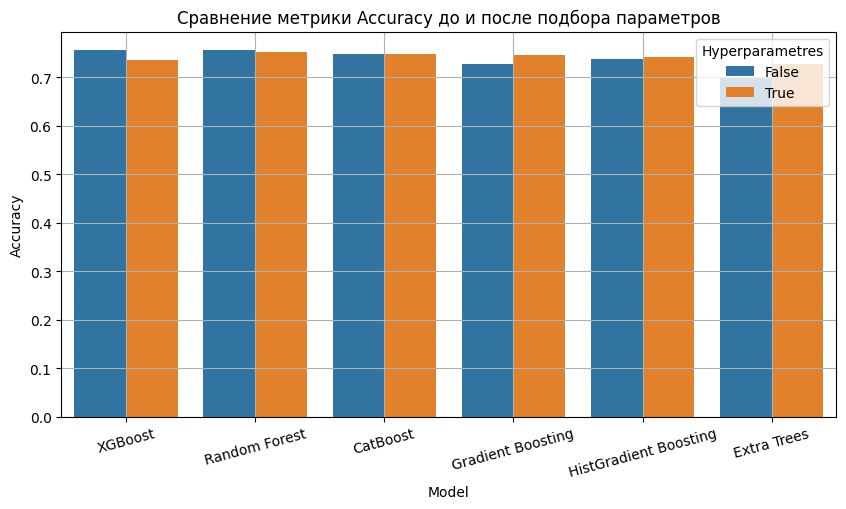

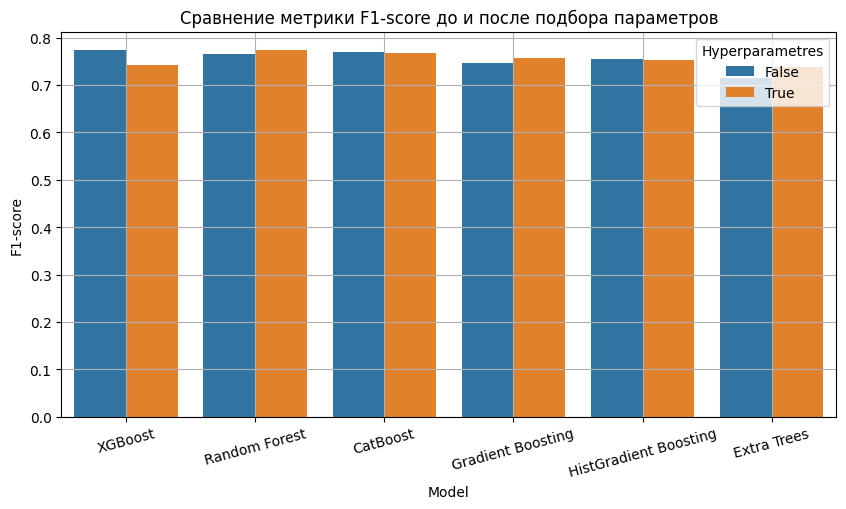

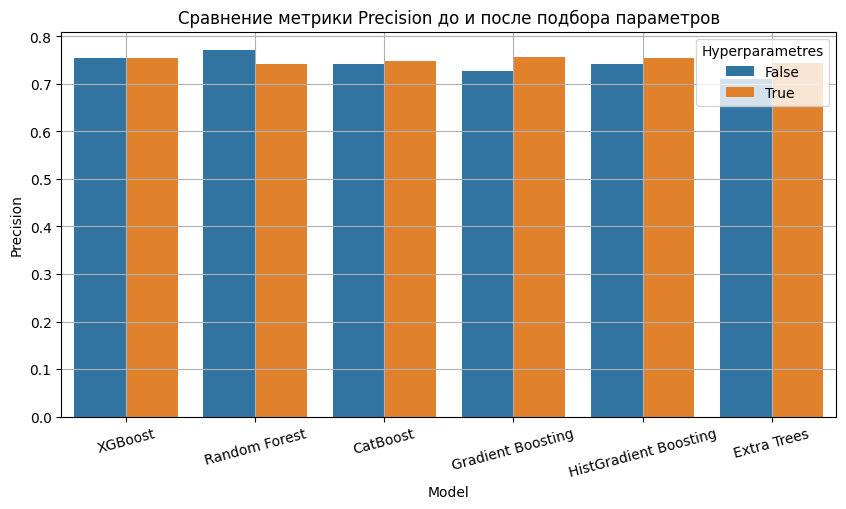

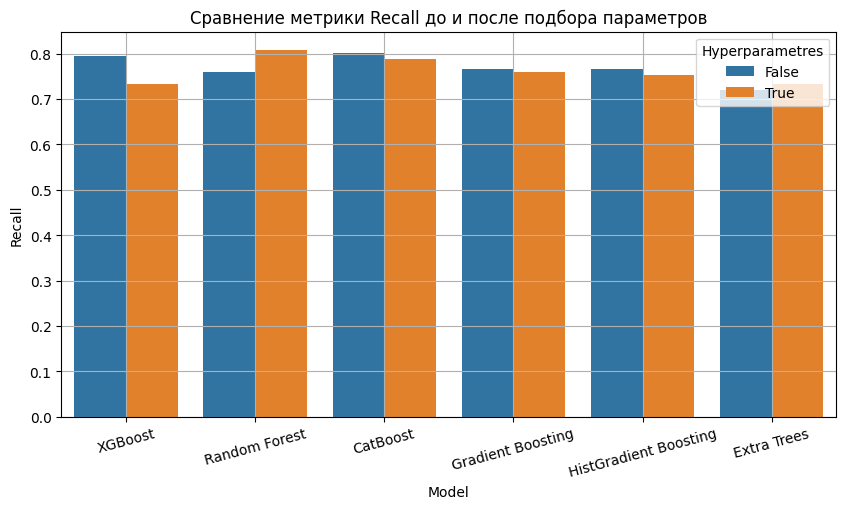

In [ ]:
# Визуализация сравнения моделей по метрикам (Accuracy, F1-score, Precision, Recall) до и после подбора гиперпараметров
metrics_to_plot = ['Accuracy', 'F1-score', 'Precision', 'Recall']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=all_results, x='Model', y=metric, hue='Hyperparametres')
    plt.title(f'Сравнение метрики {metric} до и после подбора параметров')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.grid(True)
    plt.show()


In [ ]:
# Анализ результатов: определение лучших и худших моделей по метрикам, выбор модели с минимальным RMSE и выявление моделей, у которых тюнинг не дал улучшений
tuned_only = all_results[all_results['Hyperparametres'] == True].copy()
baseline = all_results[all_results['Hyperparametres'] == False].copy()

# Модель, выбранная для дальнейшей оптимизации
chosen_model = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']

# Проход по метрикам
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    print(f"\nМетрика: {metric}")

    ascending = False

    best_model = all_results.sort_values(metric, ascending=ascending).iloc[0]
    worst_model = all_results.sort_values(metric, ascending=not ascending).iloc[0]

    print(f"Лучшая модель: **{best_model['Model']}** → {metric} = {best_model[metric]:.4f}")
    print(f"Худшая модель: **{worst_model['Model']}** → {metric} = {worst_model[metric]:.4f}")

    # Сравнение тюнингованных с базовыми версиями
    merged = tuned_only.merge(
        baseline,
        on='Model',
        suffixes=('_tuned', '_base')
    ).drop_duplicates('Model')

    stagnant = merged[merged[f'{metric}_tuned'] <= merged[f'{metric}_base']]['Model'].tolist()

    if stagnant:
        print(f"Без улучшений или хуже: {', '.join(sorted(set(stagnant)))}")


Метрика: Accuracy
Лучшая модель: **XGBoost** → Accuracy = 0.7563
Худшая модель: **Extra Trees** → Accuracy = 0.6989
Без улучшений или хуже: CatBoost, Random Forest, XGBoost

Метрика: F1-score
Лучшая модель: **Random Forest** → F1-score = 0.7738
Худшая модель: **Extra Trees** → F1-score = 0.7143
Без улучшений или хуже: CatBoost, HistGradient Boosting, XGBoost

Метрика: Precision
Лучшая модель: **Random Forest** → Precision = 0.7708
Худшая модель: **Extra Trees** → Precision = 0.7095
Без улучшений или хуже: Random Forest

Метрика: Recall
Лучшая модель: **Random Forest** → Recall = 0.8082
Худшая модель: **Extra Trees** → Recall = 0.7192
Без улучшений или хуже: CatBoost, Gradient Boosting, HistGradient Boosting, XGBoost


In [ ]:
"""
Оптимизация гиперпараметров лучшей модели с помощью Optuna:

1. Определяем лучшую модель по метрике RMSE из предыдущих результатов.
2. Задаём пространство поиска гиперпараметров, учитывая типы.
3. Запускаем Optuna для минимизации RMSE с 5-fold кросс-валидацией.
4. Обучаем финальную модель на оптимальных параметрах.
5. Вычисляем и выводим метрики качества на тесте.
6. Сравниваем финальный результат с предыдущей лучшей версией модели.
"""

# Выбираем лучшую модель
best_model_name = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']
print(f"Лучшая модель: {best_model_name}")

model_class = models[best_model_name]
param_space = param_grid[best_model_name]

def objective(trial):
    params = {}
    for param, values in param_space.items():
        # Если диапазон (tuple), предполагаем [min, max]
        if isinstance(values, tuple) and len(values) == 2:
            low, high = values
            if isinstance(low, int) and isinstance(high, int):
                params[param] = trial.suggest_int(param, low, high)
            else:
                params[param] = trial.suggest_float(param, low, high)
        # Если список, то категориальный параметр
        elif isinstance(values, list):
            # Если это список с bool или str/None - categorical
            if all(isinstance(v, bool) for v in values) or all(isinstance(v, (str,type(None))) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            # Если числа — тоже categorical (например дискретные значения)
            elif all(isinstance(v, (int,float)) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            else:
                raise ValueError(f"Unsupported list param type for '{param}': {values}")
        else:
            raise ValueError(f"Unsupported param format for '{param}': {values}")

    params['random_state'] = 42

    model = model_class.__class__(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = cross_val_score(model, X_train, y_train,
                               scoring='accuracy', cv=cv, n_jobs=-1).mean()
    return accuracy

print(f"\nЗапуск Optuna для {best_model_name}...")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nЛучшие параметры:")
print(study.best_params)

final_model = model_class.__class__(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)

print("\nФинальные метрики:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-score: {final_f1:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

prev_versions = all_results[all_results['Model'] == best_model_name]
prev_best = prev_versions.sort_values('Accuracy', ascending=False).iloc[0]

print("\nСравнение с предыдущей лучшей версией этой модели (до Optuna):")
print(f"Accuracy было: {prev_best['Accuracy']:.4f} → стало: {final_accuracy:.4f}")
print(f"Улучшение: {final_accuracy - prev_best['Accuracy']:.4f}")
print(f"F1-score было: {prev_best['F1-score']:.4f} → стало: {final_f1:.4f}")
print(f"Улучшение: {final_f1 - prev_best['F1-score']:.4f}")

[I 2025-07-27 21:24:36,349] A new study created in memory with name: no-name-2c41731e-7404-4f23-b6ec-3e1aba63bf1f


Лучшая модель: XGBoost

Запуск Optuna для XGBoost...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-27 21:24:36,588] Trial 0 finished with value: 0.7446153846153847 and parameters: {'n_estimators': 130, 'max_depth': 10, 'learning_rate': 0.13713867711785913, 'subsample': 0.8617325889154706, 'colsample_bytree': 0.9889947559983013, 'gamma': 2.6924793520521684, 'min_child_weight': 6}. Best is trial 0 with value: 0.7446153846153847.
[I 2025-07-27 21:24:36,819] Trial 1 finished with value: 0.7492307692307693 and parameters: {'n_estimators': 128, 'max_depth': 5, 'learning_rate': 0.15496592523941238, 'subsample': 0.8396149980604702, 'colsample_bytree': 0.9018695180521877, 'gamma': 1.904705665742692, 'min_child_weight': 1}. Best is trial 1 with value: 0.7492307692307693.
[I 2025-07-27 21:24:37,266] Trial 2 finished with value: 0.7384615384615384 and parameters: {'n_estimators': 215, 'max_depth': 11, 'learning_rate': 0.0718817525381755, 'subsample': 0.7260619809088416, 'colsample_bytree': 0.9656030098445109, 'gamma': 0.12449613775174007, 'min_child_weight': 7}. Best is trial 1 with 

Оптимизация гиперпараметров с помощью Optuna позволила модели XGBoost дополнительно улучшить ключевые метрики, в частности, Accuracy выросла до 0.7634, а F1-score — до 0.7871. Это подтверждает эффективность выбранного подхода и выделяет XGBoost как предпочтительный вариант для решения задачи классификации превышения медианного значения IC50.

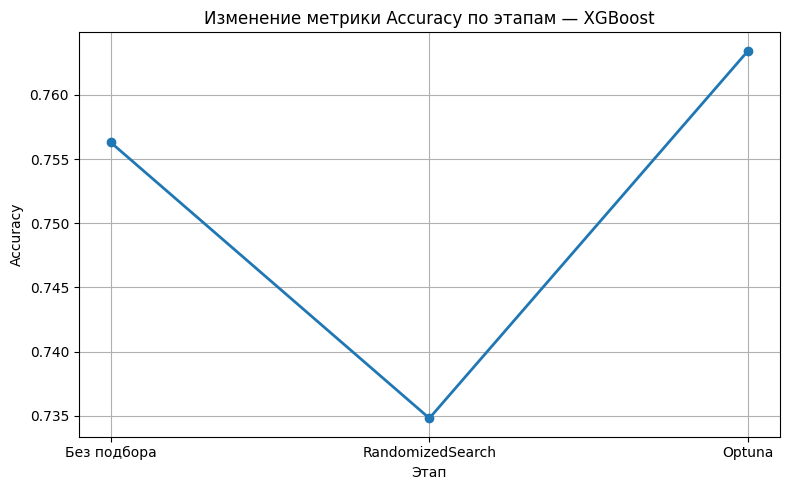

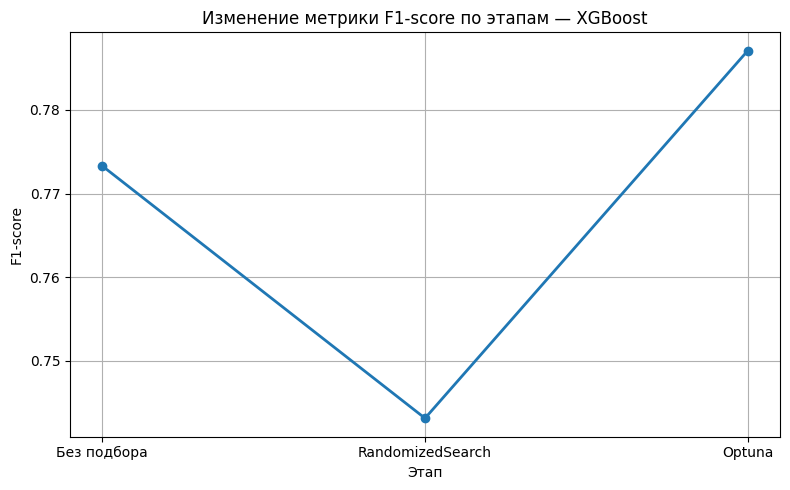

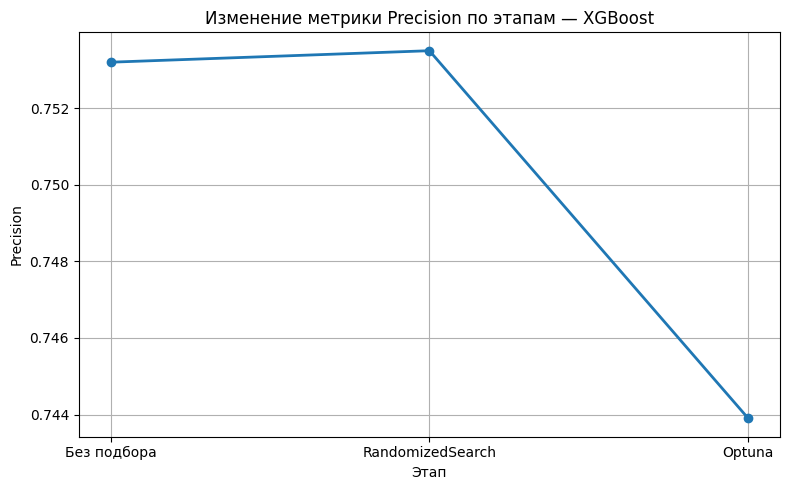

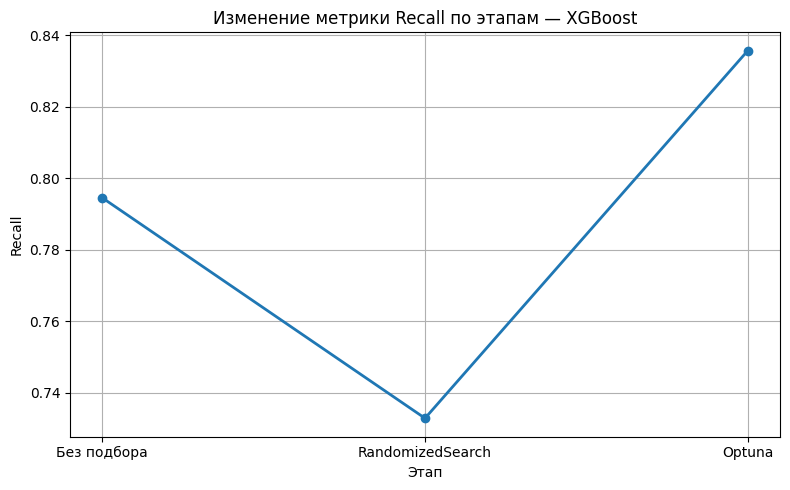

In [ ]:
target_model = best_model_name

# 1. Получаем базовую версию (без подбора)
base_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == False)].sort_values('Accuracy', ascending=False).iloc[0]

# 2. С RandomizedSearch
random_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == True)].sort_values('Accuracy', ascending=False).iloc[0]

# 3. Финальные метрики Optuna (берём из переменных после обучения)
optuna_metrics = {
    'Accuracy': final_accuracy,
    'F1-score': final_f1,
    'Precision': final_precision,
    'Recall': final_recall
}

# 4. Собираем всё в DataFrame
progress = pd.DataFrame({
    'Этап': ['Без подбора', 'RandomizedSearch', 'Optuna'],
    'Accuracy': [base_row['Accuracy'], random_row['Accuracy'], optuna_metrics['Accuracy']],
    'F1-score': [base_row['F1-score'], random_row['F1-score'], optuna_metrics['F1-score']],
    'Precision': [base_row['Precision'], random_row['Precision'], optuna_metrics['Precision']],
    'Recall': [base_row['Recall'], random_row['Recall'], optuna_metrics['Recall']],
})

# 5. Строим графики для каждой метрики
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    plt.figure(figsize=(8, 5))
    plt.plot(progress['Этап'], progress[metric], marker='o', linewidth=2)
    plt.title(f'Изменение метрики {metric} по этапам — {target_model}')
    plt.xlabel('Этап')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Исходя из анализа, оптимальной моделью для классификации превышения медианного значения IC50 является XGBoost с подбором гиперпараметров через Optuna. Она демонстрирует наилучшее сочетание точности, полноты и сбалансированности, что обеспечивает высокую надежность предсказаний.